In [1]:
import sys
sys.path.append('../..')

In [15]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_pretrained_biggan.model import Generator as orig_biggan

from model.began import Generator128
from model.biggan import BigGanSkip
from model.dcgan import Generator as dcgan_generator
from model.vae import VAE
from utils import (load_trained_net, parse_baseline_results_folder,
                   parse_results_folder)

# Store the original forward before monkey patch in BigGanSkip
orig_biggan_forward = orig_biggan.forward

In [16]:
print('Parsing results...')
parse_baseline_results_folder('../../final_runs/baseline_results')
parse_results_folder('../../final_runs/results')

Parsing results...


In [17]:
def get_top_cs(df, split, model, n_cuts, n_measure, n):
    df1 = df[(df['split'] == split) & (df['model'] == model) & 
             (df['n_cuts'] == n_cuts) & (df['n_measure'] == n_measure)]
    return df1.groupby(['image_name']).mean().sort_values(
        by='psnr', ascending=False).head(n).index.values.tolist()

def get_top_noop(df, split, model, n_cuts, n):
    df1 = df[(df['split'] == split) & (df['model'] == model) &
             (df['n_cuts'] == n_cuts) & (df['fm'] == 'NoOp')]
    return df1.groupby(['image_name']).mean().sort_values(
        by='psnr', ascending=False).head(n).index.values.tolist()

In [25]:
def cs_plot(split):
    def name_fn(row):
        if row['model'].startswith('lasso-dct'):
            return 'Lasso-DCT'
        elif row['n_cuts'] == 0:
            return 'No Surgery'
        else:
            return 'With Surgery'

    def ratio_fn(row):
        if row['type'] == 'DCGAN(64px)':
            image_size = 64
        elif row['type'] in ['BEGAN(128px)', 'VAE(128px)']:
            image_size = 128

        return row['n_measure'] / (3 * image_size * image_size)

    df_baseline = pd.read_pickle('../../final_runs/processed_results/df_baseline_results.pkl')
    df_results = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')

    if split == 'test_celeba':
        split_name = [
            'test_celeba64_cropped100',
            'test_celeba128_cropped100',
        ]
    elif split == 'ood-coco':
        split_name = ['ood-coco100']

    df1 = pd.concat([
        df_baseline.loc[(df_baseline['model'] == 'lasso-dct-64')
                        & (df_baseline['split'].isin(split_name))],
        df_results.loc[(df_results['fm'] == 'GaussianCompressiveSensing') &
                       (df_results['model'] == 'dcgan_cs') &
                       (df_results['n_cuts'].isin([0, 1])) &
                       (df_results['split'].isin(split_name))]
    ])
    df1['type'] = 'DCGAN(64px)'
    df2 = pd.concat([
        df_baseline.loc[(df_baseline['model'] == 'lasso-dct-128')
                        & (df_baseline['split'].isin(split_name))],
        df_results.loc[(df_results['fm'] == 'GaussianCompressiveSensing')
                       & (df_results['model'] == 'began_cs') &
                       (df_results['n_cuts'].isin([0, 2])) &
                       (df_results['split'].isin(split_name))]
    ])
    df2['type'] = 'BEGAN(128px)'
    df3 = pd.concat([
        df_baseline.loc[(df_baseline['model'] == 'lasso-dct-128')
                        & (df_baseline['split'].isin(split_name))],
        df_results.loc[(df_results['fm'] == 'GaussianCompressiveSensing')
                       & (df_results['model'].isin(['vanilla_vae_cs'])) &
                       (df_results['n_cuts'].isin([0, 1])) &
                       (df_results['split'].isin(split_name))]
    ])
    df3['type'] = 'VAE(128px)'

    df = pd.concat([df1, df2, df3])

    df['undersampling_ratio'] = df.apply(lambda row: ratio_fn(row), axis=1)
    df['model_name'] = df.apply(lambda row: name_fn(row), axis=1)

    sns.set(rc={'figure.figsize': (16, 9)})
    sns.set_style('ticks')
    sns.set_context('poster', font_scale=1.6)
    filled_markers = ['D', 'o', 'v', 'd', '^', '*', 'X']
    col_order = ['DCGAN(64px)', 'BEGAN(128px)', 'VAE(128px)']
    legend_order = ['With Surgery', 'No Surgery', 'Lasso-DCT']

    if split == 'test_celeba':
        title = 'CelebA'
        ylim = (10, 40)
        yt = range(10, 41, 5)
    elif split == 'ood-coco':
        title= 'COCO'
        ylim = (10, 35)
        yt = range(10, 36, 5)

    plt.figure()

    g = sns.FacetGrid(df,
                      col="type",
                      col_order=col_order,
                      hue='model_name',
                      hue_order=legend_order,
                      hue_kws=dict(marker=filled_markers),
                      height=12,
                      sharey=False,
                      aspect=1.3,
                      legend_out=True,
                      xlim=(0, 0.5),
                      ylim=ylim
                     )
    g = (g.map(sns.lineplot, "undersampling_ratio", "psnr", ci='sd', markersize=20))
    g.fig.suptitle(title)
    (g.set_xlabels(r"Undersampling Ratio ($m/n$)").set_ylabels(
        "PSNR (dB)").set_titles("{col_name}",
                                size=36).fig.subplots_adjust(bottom=0.23, top=0.87))

    g.set(xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], yticks=yt)

    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)

    os.makedirs('./figures/cs_plot', exist_ok=True)
    plt.savefig((f'./figures/cs_plot/'
                 f'cs_plot_split={split}.pdf'),
                dpi=300,
                bbox_inches='tight')

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

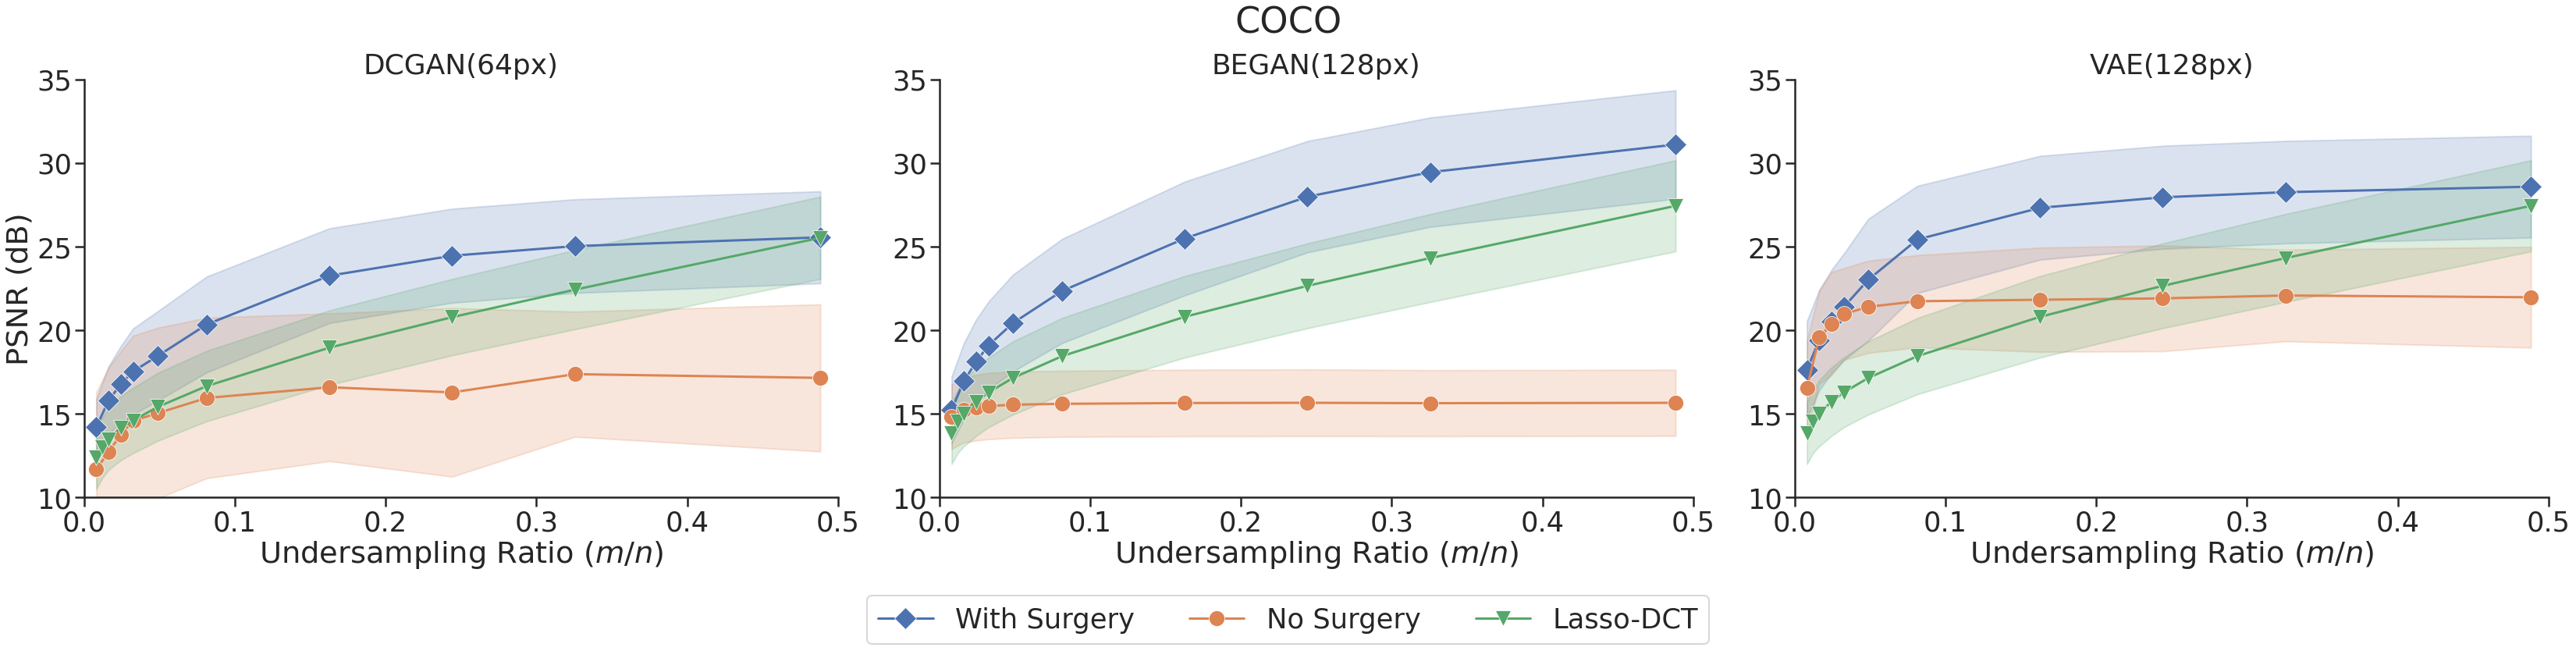

In [26]:
cs_plot('test_celeba')
cs_plot('ood-coco')

In [31]:
def cs_baselines_plot(split):
    def _name_fn(row):
        if row['model'].startswith('mgan'):
            return 'MGAN'
        elif row['model'].startswith('iagan'):
            return 'IAGAN'
        elif row['model'].startswith('deep_decoder'):
            return 'DD'
        else:
            return 'With Surgery'

    def _ratio_fn(row):
        if row['type'] == 'DCGAN(64px)':
            image_size = 64
        elif row['type'] in ['BEGAN(128px)', 'VAE(128px)']:
            image_size =128

        return row['n_measure'] / (3 * image_size * image_size)

    df_results = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')

    if split == 'test_celeba':
        split_name = ['test_celeba64_cropped100', 'test_celeba128_cropped100']
    elif split == 'ood-coco':
        split_name = ['ood-coco100']

    df1 = df_results.loc[((df_results['model'] == 'dcgan_cs') & (df_results['n_cuts'] == 1)) |
                 (df_results['model'] == 'mgan_dcgan_cs') |
                 (df_results['model'] == 'iagan_dcgan_cs') |
                 (df_results['model'] == 'deep_decoder_64_cs')].copy()
    df1['type'] = 'DCGAN(64px)'

    df2 = df_results.loc[((df_results['model'] == 'began_cs') & (df_results['n_cuts'] == 2)) |
                (df_results['model'] == 'mgan_began_cs') |
                 (df_results['model'] == 'iagan_began_cs') |
                 (df_results['model'] == 'deep_decoder_128_cs')].copy()
    df2['type'] = 'BEGAN(128px)'


    df3 = df_results.loc[((df_results['model'] == 'vanilla_vae_cs') & (df_results['n_cuts'] == 1)) |
                (df_results['model'] == 'mgan_vanilla_vae_cs') |
                 (df_results['model'] == 'iagan_vanilla_vae_cs') |
                 (df_results['model'] == 'deep_decoder_128_cs')].copy()
    df3['type'] = 'VAE(128px)'

    df = pd.concat([df1, df2, df3])
    df = df[df['split'].isin(split_name)]

    df['model_name'] = df.apply(lambda row: _name_fn(row), axis=1)
    df['undersampling_ratio'] = df.apply(lambda row: _ratio_fn(row), axis=1)

    sns.set(rc={'figure.figsize': (16, 9)})
    sns.set_style('ticks')
    sns.set_context('poster', font_scale=1.6)
    filled_markers = ['D', 'o', 'v', 'd', '^', '*', 'X']
    col_order = ['DCGAN(64px)', 'BEGAN(128px)', 'VAE(128px)']
    hue_order = ['With Surgery', 'IAGAN', 'DD', 'MGAN', ]

    if split == 'test_celeba':
        title = 'CelebA'
        ylim = (15, 45)
        yt = range(15, 46, 5)
    elif split == 'ood-coco':
        title = 'COCO'
        ylim = (15, 40)
        yt = range(15, 41, 5)

    plt.figure()

    g = sns.FacetGrid(data=df,
                      col='type',
                      col_order=col_order,
                      hue='model_name',
                      hue_order=hue_order,
                      hue_kws=dict(marker=filled_markers),
                      height=12,
                      sharey=False,
                      aspect=1.3,
                      legend_out=True,
                      xlim=(0,0.5),
                      ylim=ylim,
                     )
    g = (g.map(sns.lineplot, 'undersampling_ratio', 'psnr', ci='sd', markersize=20))
    g.fig.suptitle(title)
    (g.set_xlabels("Undersampling Ratio (m/n)").set_ylabels(
        "PSNR (dB)").set_titles("{col_name}",
                                size=36).fig.subplots_adjust(bottom=0.23, top=0.87))

    g.set(xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], yticks=yt)
    
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=4)

    os.makedirs('./figures/cs_baselines', exist_ok=True)
    plt.savefig((f'./figures/cs_baselines/'
                 f'cs_baselines_plot_split={split}.pdf'),
                dpi=300,
                bbox_inches='tight')

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

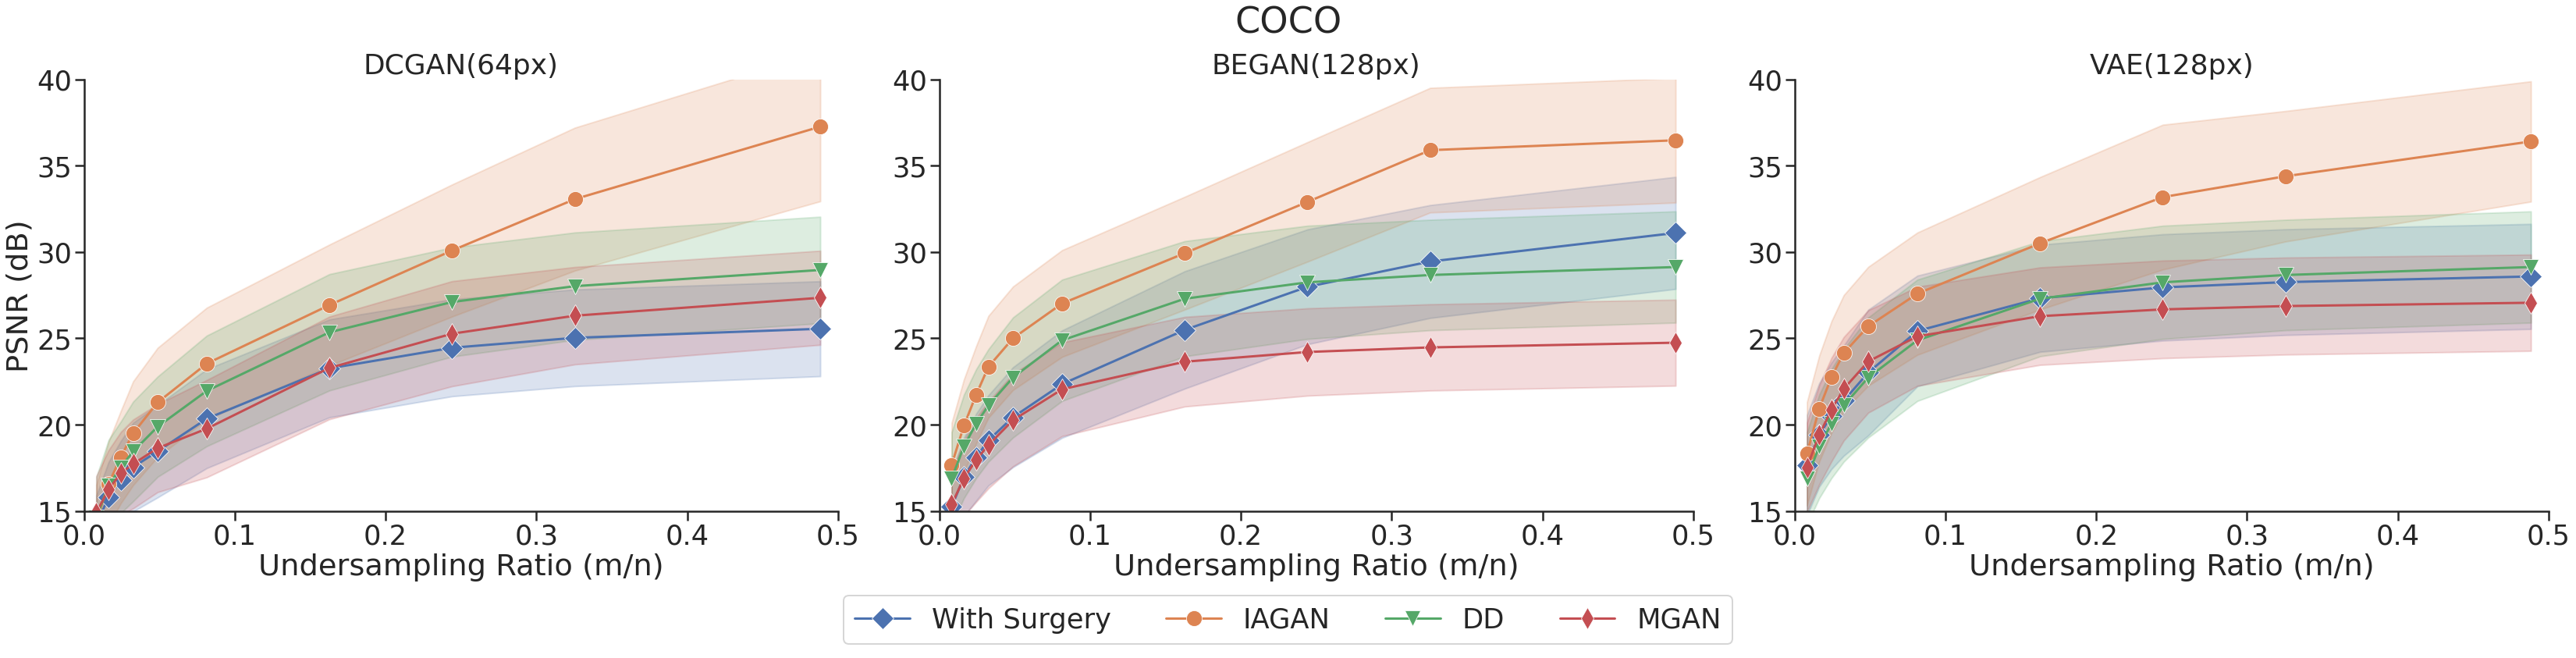

In [32]:
cs_baselines_plot('test_celeba')
cs_baselines_plot('ood-coco')

In [33]:
def cs_images(top_n):
    df = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')
    params = {
        'dcgan_cs': {
            'n_cuts': 1,
            'n_measure': 2000,
            'split': ['test_celeba64_cropped100', 'ood-coco100']
        },
        'began_cs': {
            'n_cuts': 2,
            'n_measure': 8000,
            'split': ['test_celeba128_cropped100', 'ood-coco100']
        },
        'vanilla_vae_cs': {
            'n_cuts': 1,
            'n_measure': 8000,
            'split': ['test_celeba128_cropped100', 'ood-coco100']
        }
    }

    for model, kwargs in params.items():
        os.makedirs(f'./figures/cs_images/{model}', exist_ok=True)

        for split in kwargs['split']:
            imgs = get_top_cs(df, split, model, kwargs['n_cuts'],
                              kwargs['n_measure'], top_n)
            for img in imgs:
                cs_single_image(img, split, model, kwargs['n_measure'],
                                kwargs['n_cuts'])
                plt.savefig(
                    f'./figures/cs_images/{model}/{model}_{split}_{img}.pdf',
                    dpi=300,
                    bbox_inches='tight')
                plt.close()
                
def cs_single_image(img_name, split, model, n_measure, n_cuts):
    fontsize = 18
    if n_measure == 8000:
        size = 128
    elif n_measure == 2000:
        size = 64
    else:
        raise ValueError()

    if model == 'vanilla_vae_cs':
        z_lr = 1
        n_steps = 25
    elif model == 'began_cs':
        z_lr = 1
        n_steps = 25
    elif model == 'dcgan_cs':
        z_lr = 0.1
        n_steps = 25
    else:
        raise NotImplementedError(model)

    fig, ax = plt.subplots(1, 4)
    fig.subplots_adjust(0, 0, 1, 1, 0, 0)

    # Original
    orig = torch.load(
        f'../../final_runs/images/{split}/{img_name}/{size}/original.pt').cpu(
        ).numpy().transpose([1, 2, 0])
    ax[0].imshow(np.clip(orig, 0, 1))
    ax[0].set_xlabel('Original', fontsize=fontsize)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_frame_on(False)

    # lasso
    lasso_path = f'../../final_runs/baseline_results/lasso-dct-{size}/{split}/{img_name}/n_measure={n_measure}.lasso_coeff=0.01'

    lasso_img = np.load(f'{lasso_path}/recovered.npy')
    lasso_psnr = pickle.load(open(f'{lasso_path}/psnr_clamped.pkl', 'rb'))
    ax[1].set_xlabel(f'Lasso-DCT\n{lasso_psnr:0.2f}dB', fontsize=fontsize)
    ax[1].imshow(np.clip(lasso_img, 0, 1))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_frame_on(False)

    # n_cuts=0
    n_0_path = f'../../final_runs/results/{model}/n_cuts=0/{split}/{img_name}/GaussianCompressiveSensing.n_measure={n_measure}/optimizer=lbfgs.n_steps={n_steps}.z_lr={z_lr}.restarts=3.n_cuts=0.z_init_mode=clamped_normal.limit=1'
    n0_img = torch.load(f'{n_0_path}/recovered.pt').cpu().numpy().transpose(
        [1, 2, 0])
    n0_psnr = pickle.load(open(f'{n_0_path}/psnr_clamped.pkl', 'rb'))

    ax[2].set_xlabel(f'No Surgery\n{n0_psnr:0.2f}dB', fontsize=fontsize)
    ax[2].imshow(np.clip(n0_img, 0, 1))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_frame_on(False)

    # n_cuts=best
    n_chosen_path = f'../../final_runs/results/{model}/n_cuts={n_cuts}/{split}/{img_name}/GaussianCompressiveSensing.n_measure={n_measure}/optimizer=lbfgs.n_steps={n_steps}.z_lr={z_lr}.restarts=3.n_cuts={n_cuts}.z_init_mode=clamped_normal.limit=1'
    n_chosen_img = torch.load(
        f'{n_chosen_path}/recovered.pt').cpu().numpy().transpose([1, 2, 0])
    n_chosen_psnr = pickle.load(open(f'{n_chosen_path}/psnr_clamped.pkl',
                                     'rb'))

    ax[3].imshow(np.clip(n_chosen_img, 0, 1))
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[3].set_frame_on(False)
    ax[3].set_xlabel(f'With Surgery\n{n_chosen_psnr:0.2f}dB',
                     fontsize=fontsize)

    return fig

In [34]:
cs_images(20)

In [37]:
def noop_images(top_n):
    df = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')

    params = {
        'dcgan_noop': {
            'n_cuts': 1,
            'size': 64,
        },
        'began_noop': {
            'n_cuts': 2,
            'size': 128,
        },
        'vanilla_vae_noop': {
            'n_cuts': 1,
            'size': 128
        },
    }

    for split in [
            'test_celeba64_cropped100', 'test_celeba128_cropped100',
            'ood-coco100'
    ]:
        for model, kwargs in params.items():
            os.makedirs(f'./figures/noop_images/{model}', exist_ok=True)
            imgs = get_top_noop(df, split, model, kwargs['n_cuts'], top_n)
            if len(imgs) == 0:
                continue
            for img in imgs:
                noop_single_image(img, split, model, kwargs['size'],
                                  kwargs['n_cuts'])
                plt.savefig(
                    f'./figures/noop_images/{model}/{model}_{split}_{img}.png',
                    dpi=300,
                    bbox_inches='tight')
                plt.close()
                
def noop_single_image(img_name, split, model, size, n_cuts):
    if model == 'dcgan_noop':
        # title_fontsize = 40
        # label_fontsize = 32
        # model_name = "DCGAN"
        z_lr = 1
        n_steps = 100
    elif model == 'began_noop':
        # title_fontsize = 40
        # label_fontsize = 32
        # model_name = "BEGAN"
        z_lr = 1
        n_steps = 100
    elif model in ['vanilla_vae_noop']:
        # title_fontsize = 40
        # label_fontsize = 32
        # model_name = 'VAE' if model == 'vanilla_vae' else 'β-VAE'
        z_lr = 1
        n_steps = 40
    else:
        raise NotImplementedError(model)

    fig, ax = plt.subplots(1, 3, figsize=(10, 20))
    fig.subplots_adjust(0, 0, 1, 1, 0, 0)

    # Original
    orig = torch.load(
        f'../../final_runs/images/{split}/{img_name}/{size}/original.pt').cpu(
        ).numpy().transpose([1, 2, 0])
    ax[0].imshow(np.clip(orig, 0, 1))
    # ax[0].set_xlabel('Original', fontsize=label_fontsize)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_frame_on(False)

    # Naive model
    n_0_path = f'../../final_runs/results/{model}/n_cuts=0/{split}/{img_name}/NoOp/optimizer=lbfgs.n_steps={n_steps}.z_lr={z_lr}.restarts=3.n_cuts=0.z_init_mode=clamped_normal.limit=1'
    n0_img = torch.load(
            f'{n_0_path}/recovered.pt').cpu().numpy().transpose([1, 2, 0])
    # n0_psnr = pickle.load(open(f'{n_0_path_a}/psnr_clamped.pkl', 'rb'))

    # ax[1].set_title(model_name, fontsize=title_fontsize)
    # ax[1].set_xlabel(f'No Surgery\n{n0_psnr:0.2f}dB', fontsize=label_fontsize)
    ax[1].imshow(np.clip(n0_img, 0, 1))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_frame_on(False)

    # Best model
    n_chosen_path = f'../../final_runs/results/{model}/n_cuts={n_cuts}/{split}/{img_name}/NoOp/optimizer=lbfgs.n_steps={n_steps}.z_lr={z_lr}.restarts=3.n_cuts={n_cuts}.z_init_mode=clamped_normal.limit=1'
    n_chosen_img = torch.load(
        f'{n_chosen_path}/recovered.pt').cpu().numpy().transpose(
            [1, 2, 0])
    # n_chosen_psnr = pickle.load(
    #     open(f'{n_chosen_path_a}/psnr_clamped.pkl', 'rb'))

    # ax[2].set_xlabel(f'With Surgery\n{n_chosen_psnr:0.2f}dB', fontsize=label_fontsize)
    ax[2].imshow(np.clip(n_chosen_img, 0, 1))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_frame_on(False)

    return fig

In [38]:
noop_images(20)

In [66]:
def noop_plot():
    df_results = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')

    def _name_fn(row):
        if row['model'].startswith('dcgan'):
            return 'DCGAN'
        elif row['model'].startswith('began'):
            return 'BEGAN'
        elif row['model'].startswith('vanilla_vae'):
            return 'VAE'
        else:
            return ''

    def _type_fn(row):
        if row['n_cuts'] == 0:
            return 'No Surgery'
        else:
            return 'With Surgery'

    def _split_fn(row):
        if 'celeba' in row['split']:
            return 'CelebA'
        elif row['split'] == 'ood-coco100':
            return 'COCO'
        else:
            return ''

    # Filters
    df = df_results.loc[(df_results['model'].isin(
        ['began_noop', 'vanilla_vae_noop', 'dcgan_noop']))
                        & (df_results['split'].isin([
                            'test_celeba64_cropped100',
                            'test_celeba128_cropped100', 'ood-coco100'
                        ]))]
    df = df.loc[((df['model'] == 'began_noop') & (df['n_cuts'].isin([0, 2]))) |
                ((df['model'] == 'vanilla_vae_noop') &
                 (df['n_cuts'].isin([0, 1]))) |
                ((df['model'] == 'dcgan_noop') & (df['n_cuts'].isin([0, 1])))]

    df.loc[:, 'model_name'] = pd.Series(df.apply(lambda row: _name_fn(row),
                                                 axis=1),
                                        index=df.index).values
    df.loc[:, 'type'] = pd.Series(df.apply(lambda row: _type_fn(row), axis=1),
                                  index=df.index).values
    df.loc[:, 'split_name'] = pd.Series(df.apply(lambda row: _split_fn(row),
                                                 axis=1),
                                        index=df.index).values

    sns.set(rc={'figure.figsize': (16, 9)})
    sns.set_style('ticks')
    sns.set_context('poster', font_scale=1.4)

    legend_order = ['No Surgery', 'With Surgery']
    model_order = ['DCGAN', 'BEGAN', 'VAE']
    split_order = ['CelebA', 'COCO']

    g = sns.catplot(data=df,
                    x="model_name",
                    order=model_order,
                    y="psnr",
                    col="split_name",
                    col_order=split_order,
                    hue='type',
                    hue_order=legend_order,
                    sharey=False,
                    palette=sns.color_palette("hls", 2),
                    kind="box",
                    height=12,
                    aspect=1.3,
                    legend=False)
    (g.set_xlabels("").set_xticklabels(model_order, fontsize=24).set_ylabels(
        "PSNR (dB)").set_titles("{col_name}").fig.subplots_adjust(top=0.87,
                                                                  bottom=0.14))
    g.set(ylim=(0, 50), yticks=range(0, 51, 10))

    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles,
                 labels=labels,
                 loc='lower center',
                 ncol=2,
                 fontsize=28)

    os.makedirs('./figures/noop_plot', exist_ok=True)
    plt.savefig(f'./figures/noop_plot/noop_box.pdf',
                dpi=300,
                bbox_inches='tight')

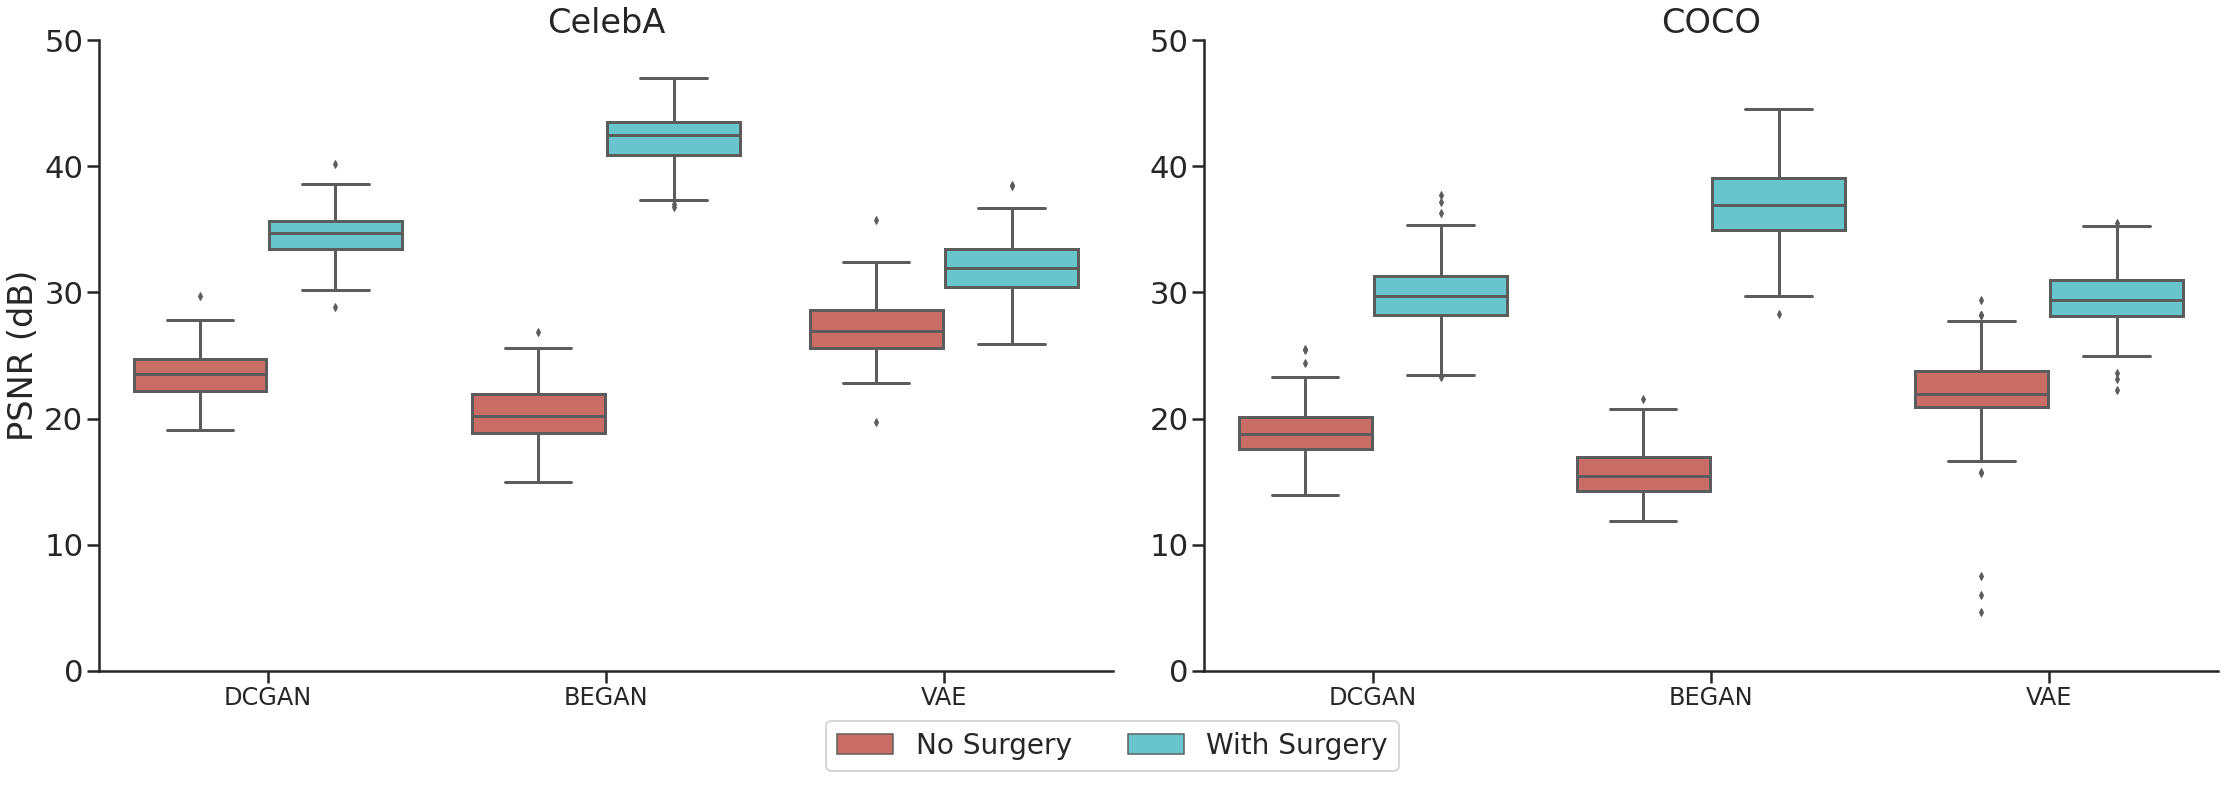

In [67]:
noop_plot()

In [72]:
def opt_error_plot():
    def split_fn(row):
        if row['split'] == 'train_celeba128_cropped100':
            return 'Train'
        elif row['split'] == 'test_celeba128_cropped100':
            return 'Test'
        elif row['split'] == 'ood-coco100':
            return 'COCO'
        elif row['split'] == 'began_generated100':
            return 'Generated'
        else:
            return ''

    def type_fn(row):
        if row['n_cuts'] == 0:
            return 'No Surgery'
        else:
            return 'With Surgery'

    df = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')

    df = df.loc[((df['model'] == 'began_opt_error_fake_imgs') &
                 (df['split'].isin([
                     'train_celeba128_cropped100', 'test_celeba128_cropped100',
                     'began_generated100', 'ood-coco100'
                 ])))]
    df['split_name'] = df.apply(lambda row: split_fn(row), axis=1)
    df['type'] = df.apply(lambda row: type_fn(row), axis=1)

    sns.set(rc={'figure.figsize': (16, 9)})
    sns.set_context('poster', font_scale=1.6)
    sns.set_style('ticks')
    legend_order = ['No Surgery', 'With Surgery']
    split_order = ['Train', 'Test', 'COCO', 'Generated']

    plt.figure()
    ax = sns.boxplot(data=df,
                     x="split_name",
                     y="psnr",
                     order=split_order,
                     hue='type',
                     hue_order=legend_order,
                     palette=sns.color_palette("hls", 2),
                     dodge=True)
    ax.set_xlabel("Image source")
    ax.set_ylabel("PSNR (dB)")
    ax.set_ylim(10, 60)
    ax.set_yticks(range(10, 61, 10))
    ax.set_title("Optimization Error")

    # Remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(frameon=False,
              handles=handles[0:],
              labels=labels[0:],
              loc='upper left',
              fontsize=24)

    os.makedirs('./figures/opt_error', exist_ok=True)
    plt.savefig(f'./figures/opt_error/opt_error.pdf',
                dpi=300,
                bbox_inches='tight')

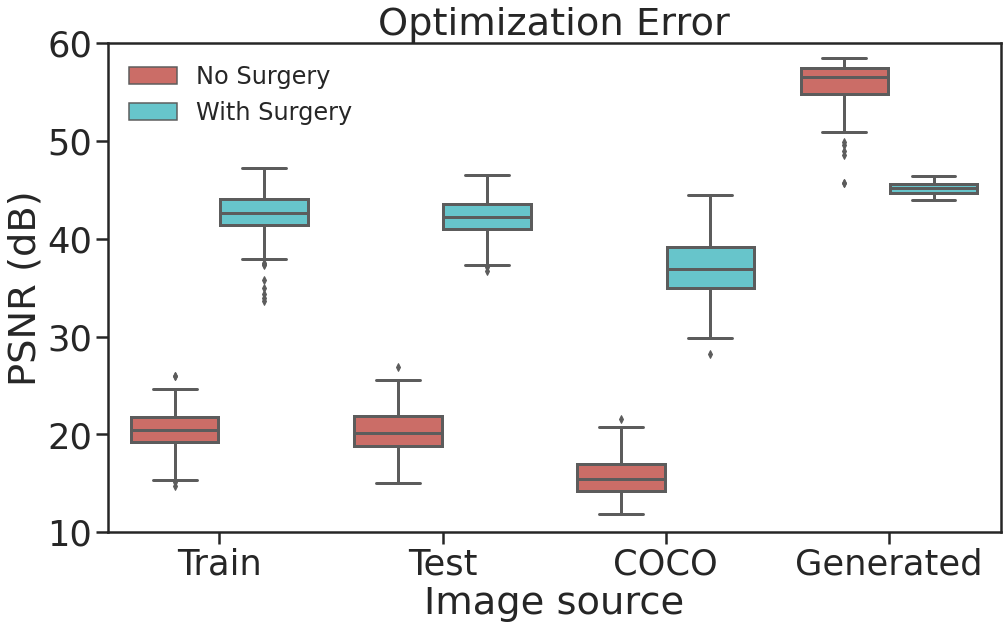

In [73]:
opt_error_plot()

In [74]:
def cs_other_init_plot(split, n_measure):
    def init_name_fn(row):
        if row['z_init_mode'] == 'zero':
            return 'Zero'
        elif row['z_init_mode'] == 'lasso_inverse':
            return 'LassoInv'
        elif row['z_init_mode'] == 'normal':
            return f'N(0,{int(row["limit"])})'
        elif row['z_init_mode'] == 'clamped_normal':
            return 'CN(0,1)'
        else:
            return 'Lasso-DCT'

    df_baseline = pd.read_pickle('../../final_runs/processed_results/df_baseline_results.pkl')
    df_results = pd.read_pickle('../../final_runs/processed_results/df_results.pkl')
        
    df = pd.concat([
        df_baseline.loc[(df_baseline['model'] == 'lasso-dct-128')
                        & (df_baseline['n_measure'] == n_measure)],
        df_results.loc[(df_results['fm'] == 'GaussianCompressiveSensing')
                       & (df_results['model'] == 'began_cs_other_init') &
                       (df_results['n_cuts'].isin([2])) &
                       (df_results['n_measure'] == n_measure)]
    ])

    df = df.loc[df['split'] == split]
    df['init_name'] = df.apply(lambda row: init_name_fn(row), axis=1)

    sns.set(rc={'figure.figsize': (20, 10)})
    sns.set_style('ticks')
    sns.set_context('poster', font_scale=2)

    mode_order = [
        'Lasso-DCT', 'Zero', 'CN(0,1)', 'LassoInv', 'N(0,5)', 'N(0,10)'
    ]

    plt.figure()

    ax = sns.boxplot(
        x='init_name',
        y='psnr',
        data=df,
        order=mode_order,
    )

    if 'celeba' in split:
        title = f'CelebA'
    elif split == 'ood-coco100':
        title = f'COCO'

    ax.set_ylim(10, 40)
    ax.set_xlabel('Initialization Strategy')
    ax.set_xticklabels(mode_order, fontsize=36)
    ax.set_ylabel('PSNR (dB)')
    ax.set_title(title)

    os.makedirs('./figures/cs_other_init', exist_ok=True)
    plt.savefig((f'./figures/cs_other_init/'
                 f'cs_other_init_n_measure={n_measure}_split={split}.pdf'),
                dpi=300,
                bbox_inches='tight')

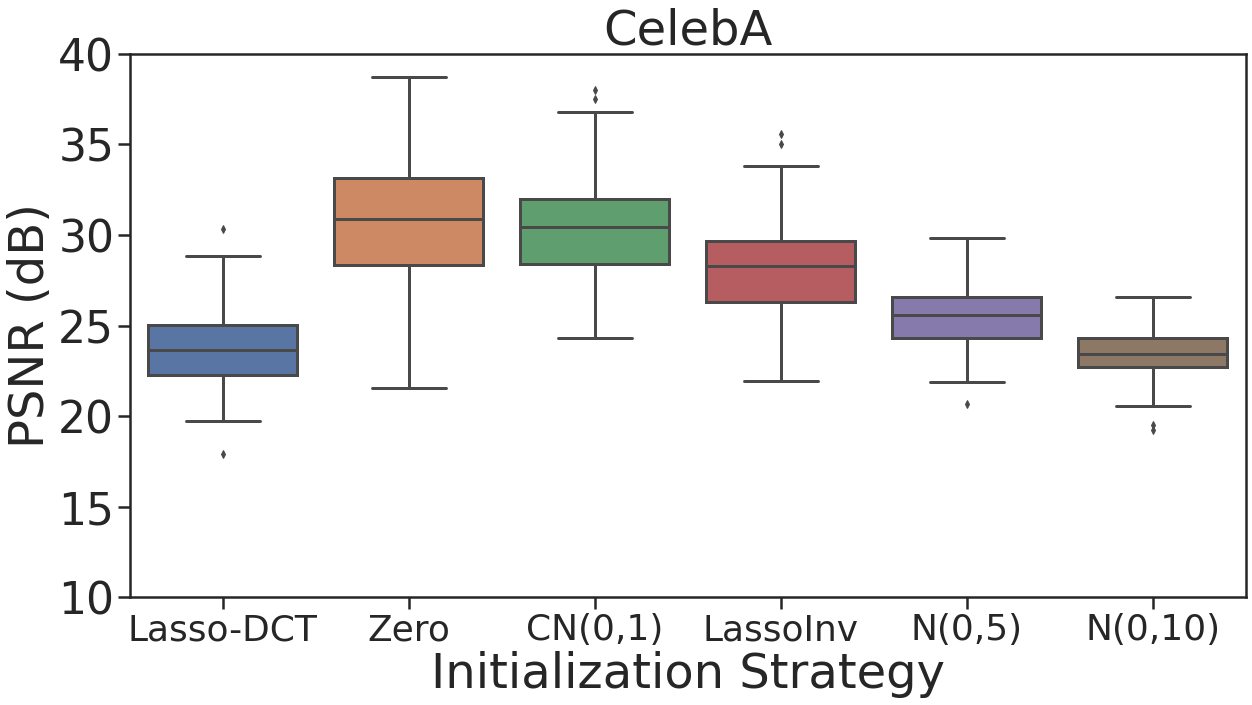

In [75]:
cs_other_init_plot('test_celeba128_cropped100', 8000)
cs_other_init_plot('ood-coco100', 8000)

In [76]:
def best_cuts_plot(model):
    def split_fn(row):
        if 'celeba' in row['split']:
            return 'CelebA'
        elif 'ood' in row['split']:
            return 'COCO'
        else:
            return ''

    df_results = pd.read_pickle(
        '../../final_runs/processed_results/df_results.pkl')
    df = df_results.loc[df_results['model'] == model]
    df.loc[:, 'split_name'] = df.apply(lambda row: split_fn(row), axis=1)

    sns.set(rc={'figure.figsize': (16, 9)})
    sns.set_style('ticks')
    sns.set_context('poster', font_scale=1.8)
    filled_markers = ['d', 'o']
    legend_order = ['CelebA', 'COCO']
    if model == 'dcgan_cs_n_cuts':
        title = 'DCGAN'
        xlim = (0, 4)
        xticks = list(range(0, 5))
        ylim = (5, 35)
    elif model == 'began_cs_n_cuts':
        title = 'BEGAN'
        xlim = (0, 13)
        xticks = list(range(0, 14))
        ylim = (5, 35)
    elif model == 'vanilla_vae_cs_n_cuts':
        title = 'VAE'
        xlim = (0, 5)
        xticks = list(range(0, 6))
        ylim = (5, 35)
    else:
        raise NotImplementedError()

    plt.figure()
    ax = sns.lineplot(data=df,
                      x='n_cuts',
                      y='psnr',
                      hue='split_name',
                      hue_order=legend_order,
                      ci='sd',
                      style='split_name',
                      style_order=legend_order,
                      markers=filled_markers,
                      markersize=20,
                      dashes=False)

    ax.set_title(title, fontsize=50)
    ax.set_xlabel('No. of cuts')
    ax.set_ylabel('PSNR (dB)')

    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_ylim(ylim)

    # # Remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(frameon=False,
              handles=handles[1:],
              labels=labels[1:],
              loc='upper right')

    os.makedirs('./figures/best_cuts', exist_ok=True)
    plt.savefig((f'./figures/best_cuts/'
                 f'best_cuts_model={model}.pdf'),
                dpi=300,
                bbox_inches='tight')

In [77]:
best_cuts_plot('dcgan_cs_n_cuts')
best_cuts_plot('began_cs_n_cuts')
best_cuts_plot('vanilla_vae_cs_n_cuts')

FileNotFoundError: [Errno 2] No such file or directory: './final_runs/processed_results/df_results.pkl'

In [88]:
def generator_samples(model):
    if model == 'began':
        g = Generator128(64).to('cuda:0')
        g = load_trained_net(
            g, ('../../checkpoints/celeba_began.withskips.bs32.cosine.min=0.25'
                '.n_cuts=0/gen_ckpt.49.pt'))
    elif model == 'vae':
        g = VAE().to('cuda:0')
        g.load_state_dict(
            torch.load('../../vae_checkpoints/vae_bs=128_beta=1.0/epoch_19.pt'))
        g = g.decoder
    elif model == 'biggan':
        g = BigGanSkip().to('cuda:0')
    elif model == 'dcgan':
        g = dcgan_generator().to('cuda:0')
        g.load_state_dict(
            torch.load(('../../dcgan_checkpoints/netG.epoch_24.n_cuts_0.bs_64'
                        '.b1_0.5.lr_0.0002.pt')))
    else:
        raise NotImplementedError

    nseed = 10
    n_cuts_list = [0, 1, 2, 3, 4, 5]

    fig, ax = plt.subplots(len(n_cuts_list),
                           nseed,
                           figsize=(10, len(n_cuts_list)))
    for row, n_cuts in enumerate(n_cuts_list):
        input_shapes = g.input_shapes[n_cuts]
        z1_shape = input_shapes[0]
        z2_shape = input_shapes[1]

        for col in range(nseed):
            torch.manual_seed(col)
            np.random.seed(col)
            if n_cuts == 0 and model == 'biggan':
                class_vector = torch.tensor(
                    949, dtype=torch.long).to('cuda:0').unsqueeze(
                        0)  # 949 = strawberry
                embed = g.biggan.embeddings(
                    torch.nn.functional.one_hot(
                        class_vector, num_classes=1000).to(torch.float))
                cond_vector = torch.cat(
                    (torch.randn(1, 128).to('cuda:0'), embed), dim=1)

                img = orig_biggan_forward(
                    g.biggan.generator, cond_vector,
                    truncation=1.0).detach().cpu().squeeze(
                        0).numpy().transpose([1, 2, 0])
            elif n_cuts > 0 and model == 'biggan':
                z1 = torch.randn(1, *z1_shape).to('cuda:0')

                class_vector = torch.tensor(
                    949, dtype=torch.long).to('cuda:0').unsqueeze(
                        0)  # 949 = strawberry
                embed = g.biggan.embeddings(
                    torch.nn.functional.one_hot(
                        class_vector, num_classes=1000).to(torch.float))
                cond_vector = torch.cat(
                    (torch.randn(1, 128).to('cuda:0'), embed), dim=1)
                z2 = cond_vector

                img = g(
                    z1, z2, truncation=1.0,
                    n_cuts=n_cuts).detach().cpu().squeeze(0).numpy().transpose(
                        [1, 2, 0])
            else:
                z1 = torch.randn(1, *z1_shape).to('cuda:0')
                if len(z2_shape) == 0:
                    z2 = None
                else:
                    z2 = torch.randn(1, *z2_shape).to('cuda:0')

                img = g(
                    z1, z2,
                    n_cuts=n_cuts).detach().cpu().squeeze(0).numpy().transpose(
                        [1, 2, 0])

            if g.rescale:
                img = (img + 1) / 2

            ax[row, col].imshow(np.clip(img, 0, 1), aspect='auto')
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            ax[row, col].set_frame_on(False)
            if col == 0:
                ax[row, col].set_ylabel(f'{n_cuts}', fontsize=12, rotation=0)

    fig.subplots_adjust(0, 0, 1, 1, 0, 0)
    os.makedirs('./figures/generator_samples', exist_ok=True)
    plt.savefig((f'./figures/generator_samples/'
                 f'model={model}.pdf'),
                dpi=300,
                bbox_inches='tight')

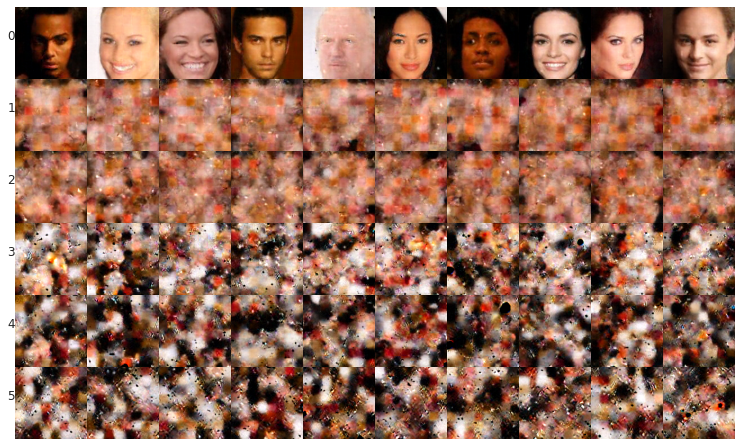

In [89]:
generator_samples('dcgan')
generator_samples('began')
generator_samples('vae')

In [90]:
def cut_training(n_cols):
    began_settings = {
        1: {
            'batch_size':
            32,
            'z_lr':
            3e-5,
            'path':
            ('../../checkpoints/celeba_began.withskips.bs32.cosine.min=0.25'
             '.n_cuts=1.z_lr=3e-5/gen_ckpt.24.pt')
        },
        2: {
            'batch_size':
            32,
            'z_lr':
            8e-5,
            'path':
            ('../../checkpoints/celeba_began.withskips.bs32.cosine.min=0.25'
             '.n_cuts=1.z_lr=8e-5/gen_ckpt.19.pt')
        },
        3: {
            'batch_size':
            64,
            'z_lr':
            1e-4,
            'path':
            ('../../checkpoints/celeba_began.withskips.bs64.cosine.min=0.25'
             '.n_cuts=1.z_lr=1e-4/gen_ckpt.19.pt')
        },
        4: {
            'batch_size':
            64,
            'z_lr':
            3e-5,
            'path':
            ('../../checkpoints/celeba_began.withskips.bs64.cosine.min=0.25'
             '.n_cuts=1.z_lr=3e-5/gen_ckpt.24.pt')
        },
        5: {
            'batch_size':
            64,
            'z_lr':
            8e-5,
            'path':
            ('../../checkpoints/celeba_began.withskips.bs64.cosine.min=0.25'
             '.n_cuts=1.z_lr=8e-5/gen_ckpt.24.pt')
        }
    }

    fig, ax = plt.subplots(len(began_settings.items()),
                           n_cols,
                           figsize=(n_cols, len(began_settings.items())))

    fig.suptitle('BEGAN (cuts=1)', fontsize=16)

    for i, settings in began_settings.items():
        g = Generator128(64).to('cuda')
        g = load_trained_net(g, settings['path'])

        input_shapes = g.input_shapes[1]
        z1_shape = input_shapes[0]
        z2_shape = input_shapes[1]

        for col in range(n_cols):
            z1 = torch.randn(1, *z1_shape).clamp(-1, 1).to('cuda')
            if len(z2_shape) == 0:
                z2 = None
            else:
                z2 = torch.randn(1, *z2_shape).clamp(-1, 1).to('cuda')
            img = g.forward(
                z1, z2, n_cuts=1).detach().cpu().squeeze(0).numpy().transpose(
                    [1, 2, 0])
            ax[i - 1, col].imshow(np.clip(img, 0, 1), aspect='auto')
            ax[i - 1, col].set_xticks([])
            ax[i - 1, col].set_yticks([])
            ax[i - 1, col].set_frame_on(False)

    fig.subplots_adjust(0, 0, 1, 0.93, 0, 0)

    os.makedirs('./figures/cut_training/', exist_ok=True)
    plt.savefig(f'./figures/cut_training/began_cut_training.pdf',
                bbox_inches='tight',
                dpi=300)

    dcgan_settings = {
        1: {
            'z_lr':
            5e-5,
            'b1':
            0.5,
            'path': ('../../dcgan_checkpoints/netG.epoch_24.n_cuts_1'
                     '.bs_64.b1_0.5.lr_5e-05.pt')
        },
        2: {
            'z_lr':
            1e-4,
            'b1':
            0.5,
            'path': ('../../dcgan_checkpoints/netG.epoch_24.n_cuts_1'
                     '.bs_64.b1_0.5.lr_0.0001.pt')
        },
        3: {
            'z_lr':
            2e-4,
            'b1':
            0.5,
            'path': ('../../dcgan_checkpoints/netG.epoch_24.n_cuts_1'
                     '.bs_64.b1_0.5.lr_0.0002.pt')
        },
        4: {
            'z_lr':
            5e-5,
            'b1':
            0.9,
            'path': ('../../dcgan_checkpoints/netG.epoch_24.n_cuts_1'
                     '.bs_64.b1_0.9.lr_5e-05.pt')
        },
        5: {
            'z_lr':
            2e-4,
            'b1':
            0.9,
            'path': ('../../dcgan_checkpoints/netG.epoch_24.n_cuts_1'
                     '.bs_64.b1_0.9.lr_0.0002.pt')
        },
    }

    fig, ax = plt.subplots(len(dcgan_settings.items()),
                           n_cols,
                           figsize=(n_cols, len(dcgan_settings.items())))

    fig.suptitle('DCGAN (cuts=1)', fontsize=16)

    for i, settings in dcgan_settings.items():
        g = dcgan_generator().to('cuda')
        g.load_state_dict(torch.load(settings['path']))

        input_shapes = g.input_shapes[1]
        z1_shape = input_shapes[0]
        z2_shape = input_shapes[1]

        for col in range(n_cols):
            z1 = torch.randn(1, *z1_shape).clamp(-1, 1).to('cuda')
            if len(z2_shape) == 0:
                z2 = None
            else:
                z2 = torch.randn(1, *z2_shape).clamp(-1, 1).to('cuda')
            img = g.forward(
                z1, z2, n_cuts=1).detach().cpu().squeeze(0).numpy().transpose(
                    [1, 2, 0])
            # Rescale from [-1, 1] to [0, 1]
            img = (img + 1) / 2
            ax[i - 1, col].imshow(np.clip(img, 0, 1), aspect='auto')
            ax[i - 1, col].set_xticks([])
            ax[i - 1, col].set_yticks([])
            ax[i - 1, col].set_frame_on(False)

    fig.subplots_adjust(0, 0, 1, 0.93, 0, 0)

    os.makedirs('./figures/cut_training/', exist_ok=True)
    plt.savefig(f'./figures/cut_training/dcgan_cut_training.pdf',
                bbox_inches='tight',
                dpi=300)

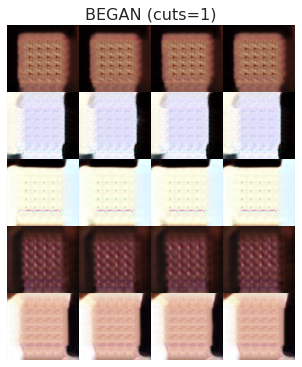

In [91]:
cut_training(4)